## Russian classical literature analysis

In [2]:
# немного импортов
import sqlalchemy
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords

import pymorphy2

from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

import itertools

In [2]:
db = sqlalchemy.create_engine('sqlite:///books/books_db.sqlite')
df = pd.read_sql_query('select * from chunk', db, index_col='chunk_id')
db.dispose()
df.head()

,author,book_id,text
chunk_id,,,
1,Иван Алексеевич Бунин,1,"В знак веры в жизнь вечную, в воскресение из м..."
2,Иван Алексеевич Бунин,1,"Ибо он, этот волчец, воистину чудесен. Сорванн..."
3,Иван Алексеевич Бунин,1,"Так утешаюсь и я, воскрешая в себе те светонос..."
4,Иван Алексеевич Бунин,1,"Роза Иерихона. В живую воду сердца, в чистую в..."
5,Иван Алексеевич Бунин,1,"Золотилось солнце на востоке, за туманной синь..."


In [3]:
morph = pymorphy2.MorphAnalyzer()

def is_cyr_word(word):
    for ch in word:
        if not ('а' <= ch <= 'я'):
            return False
    return True

def process_text(text):        
    lower = (word.lower() for word in nltk.wordpunct_tokenize(text))
    cyr = (word for word in lower if is_cyr_word(word))
    norm_form =  (morph.parse(word)[0].normal_form for word in cyr)
        
    return ' '.join(norm_form)
        
def shorten_name(name):
    splited = name.split(' ')
    if len(splited) != 3:
        return name
    
    
    i, o, f = splited
    return '%s.%s. %s' % (i[0], o[0], f)

df['words'] = df['text'].map(process_text)
df['author'] = df['author'].map(shorten_name)

df.to_csv("temp_texts.csv", index = False)

df.head()

,author,book_id,text,words
chunk_id,,,,
1,И.А. Бунин,1,"В знак веры в жизнь вечную, в воскресение из м...",в знак вера в жизнь вечный в воскресение из мё...
2,И.А. Бунин,1,"Ибо он, этот волчец, воистину чудесен. Сорванн...",ибо он этот волчец воистину чудесный сорвать и...
3,И.А. Бунин,1,"Так утешаюсь и я, воскрешая в себе те светонос...",так утешаться и я воскрешать в себя тот светон...
4,И.А. Бунин,1,"Роза Иерихона. В живую воду сердца, в чистую в...",роза иерихон в живой вода сердце в чистый влаг...
5,И.А. Бунин,1,"Золотилось солнце на востоке, за туманной синь...",золотиться солнце на восток за туманный синь д...


In [3]:
df = pd.read_csv("temp_texts.csv").dropna()
df[['author', 'text']].groupby(['author']).count()

,text
author,
А.П. Платонов,11019
А.П. Чехов,4359
А.С. Пушкин,516
Б.Л. Пастернак,2285
И.А. Бунин,2490
И.А. Гончаров,11659
И.С. Тургенев,6296
Л.Н. Толстой,4515
Н.В. Гоголь,1112


In [19]:
ru_stop_words = stopwords.words('russian')
print(ru_stop_words[0:20])
train, test = train_test_split(df, test_size=0.33)

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты']


F_score:  0.886053700224


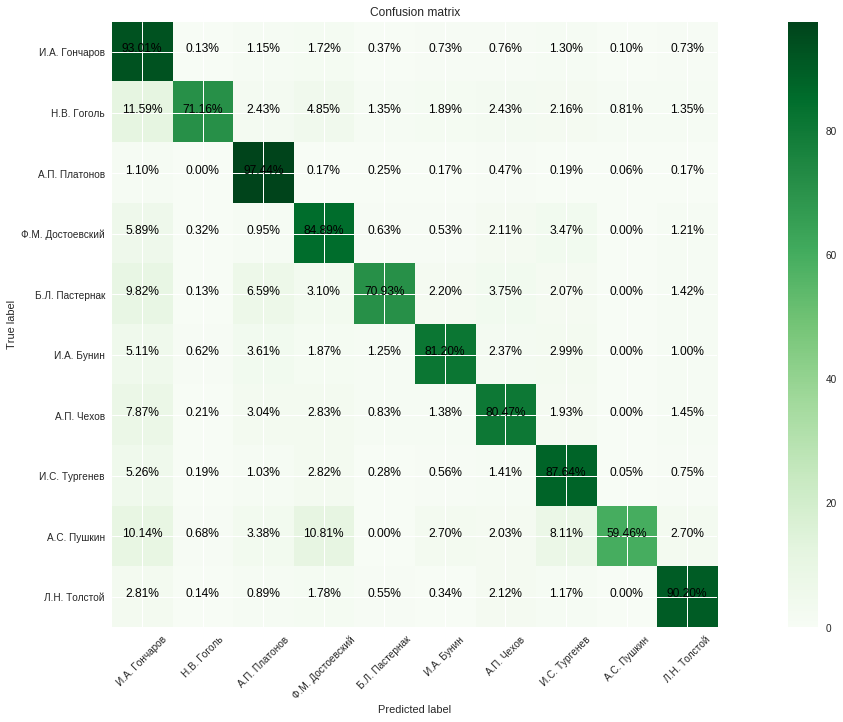

In [22]:

tf_idf = TfidfVectorizer(max_df=0.7, min_df=5, stop_words=ru_stop_words)
clf = LinearSVC()

pipeline = Pipeline([('tf-idf', tf_idf), ('clf', clf)])

def plot_confusion_matrix(cm, classes,               
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):

    plt.figure(figsize=(20,10))
    
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100.
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
      
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, 
                 '%.2f%%' %  cm[i, j],
                 horizontalalignment='center',
                 color='black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    
def pipe(clf, train, test):
    clf.fit(train['words'], train['author'])
    
    pred = clf.predict(test['words'])
    
    score = metrics.f1_score(test['author'], pred, average='micro')
    
    authors = list(train['author'].unique())
    cm = metrics.confusion_matrix(test['author'], pred, labels=authors)
    
    plt.figure(figsize=(20,10))
    plot_confusion_matrix(cm, authors)
    
    return clf, score

clf,score = pipe(pipeline, train, test)

print('F_score: ', score)
plt.show()


## Let look on neural network base embeddings -- Word2Vec


In [7]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

def chunk_to_sentences(text):
    raw_sentences = tokenizer.tokenize(text.strip())
    sentences = []
    for sentence in raw_sentences:
        lower = (word.lower() for word in nltk.wordpunct_tokenize(sentence))
        cyr = (word for word in lower if is_cyr_word(word))
        norm_form =  list(morph.parse(word)[0].normal_form for word in cyr)
        if len(norm_form) > 0:
            sentences.append(norm_form)
    return sentences
df['sentences'] = df['text'].map(chunk_to_sentences)
rows = []
for i, row in df.iterrows():
    for sent in row.sentences:
        new_row = [' '.join(sent)]
        new_row.extend(row.tolist()[:-1])
        rows.append(new_row)
        
df_sent = pd.DataFrame(rows, columns=['sentences','author','id','test','words'])

df_sent.to_csv("with_sentences.csv", index = False)
df_sent

,sentences,author,id,test,words
0,в знак вера в жизнь вечный в воскресение из мё...,И.А. Бунин,1,"В знак веры в жизнь вечную, в воскресение из м...",в знак вера в жизнь вечный в воскресение из мё...
1,странно что назвать роза да ещё роза иерихон э...,И.А. Бунин,1,"В знак веры в жизнь вечную, в воскресение из м...",в знак вера в жизнь вечный в воскресение из мё...
2,ибо он этот волчец воистину чудесный,И.А. Бунин,1,"Ибо он, этот волчец, воистину чудесен. Сорванн...",ибо он этот волчец воистину чудесный сорвать и...
3,сорвать и унести странник за тысяча верста от ...,И.А. Бунин,1,"Ибо он, этот волчец, воистину чудесен. Сорванн...",ибо он этот волчец воистину чудесный сорвать и...
4,но быть положить в вода тотчас начинать распус...,И.А. Бунин,1,"Ибо он, этот волчец, воистину чудесен. Сорванн...",ибо он этот волчец воистину чудесный сорвать и...
5,и бедный человеческий сердце радоваться утешат...,И.А. Бунин,1,"Ибо он, этот волчец, воистину чудесен. Сорванн...",ибо он этот волчец воистину чудесный сорвать и...
6,так утешаться и я воскрешать в себя тот светон...,И.А. Бунин,1,"Так утешаюсь и я, воскрешая в себе те светонос...",так утешаться и я воскрешать в себя тот светон...
7,роза иерихон,И.А. Бунин,1,"Роза Иерихона. В живую воду сердца, в чистую в...",роза иерихон в живой вода сердце в чистый влаг...
8,в живой вода сердце в чистый влага любовь печа...,И.А. Бунин,1,"Роза Иерихона. В живую воду сердца, в чистую в...",роза иерихон в живой вода сердце в чистый влаг...
9,отдалиться,И.А. Бунин,1,"Роза Иерихона. В живую воду сердца, в чистую в...",роза иерихон в живой вода сердце в чистый влаг...


In [40]:
df_sent = pd.read_csv("with_sentences.csv")


num_features = 150    
context = 5                                                                                        
min_word_count = 3                        
num_workers = 4       

from gensim.models import word2vec

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

print("Training model...")
model = word2vec.Word2Vec([s.split(' ') for s in df_sent['sentences'].values], workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)
model.init_sims(replace=True)

model_name = "150features_5context"
model.save(model_name)

Training model...


2017-07-09 21:33:51,009 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2017-07-09 21:33:51,061 : INFO : collecting all words and their counts
2017-07-09 21:33:51,062 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-07-09 21:33:51,134 : INFO : PROGRESS: at sentence #10000, processed 147056 words, keeping 12525 word types
2017-07-09 21:33:51,176 : INFO : PROGRESS: at sentence #20000, processed 257660 words, keeping 17243 word types
2017-07-09 21:33:51,214 : INFO : PROGRESS: at sentence #30000, processed 375709 words, keeping 20253 word types
2017-07-09 21:33:51,259 : INFO : PROGRESS: at sentence #40000, processed 482450 words, keeping 22580 word types
2017-07-09 21:33:51,318 : INFO : PROGRESS: at sentence #50000, processed 593276 words, keeping 24391 word types
2017-07-09 21:33:51,380 : INFO : PROGRESS: at sentence #60000, processed 710502 words, keeping 26999 word types
2017-07-09 21:33:51,434 : INFO : PROGRESS: at sente

In [31]:
print("лишний - отец сын мать кот: " + model.doesnt_match("отец сын мать кот".split()))
print("лишний - париж москва петербург франция: " + model.doesnt_match("париж москва петербург франция".split())+ "\n")
print(str(model.most_similar("отец")) + "\n")

print(str(model.most_similar("корабль")))

лишний - отец сын мать кот: кот
лишний - париж москва петербург франция: франция

[('матерь', 0.8889983296394348), ('жена', 0.854743480682373), ('муж', 0.8514267802238464), ('мать', 0.8387153744697571), ('сын', 0.8287318348884583), ('сестра', 0.8167253136634827), ('брат', 0.7668951153755188), ('тётка', 0.765466570854187), ('дочь', 0.741264820098877), ('ребёнок', 0.7404596209526062)]

[('остров', 0.9027515053749084), ('пароход', 0.8877909183502197), ('избушка', 0.86659836769104), ('север', 0.8622997403144836), ('стадо', 0.8614086508750916), ('судно', 0.8607655763626099), ('колхозный', 0.8601011037826538), ('мельница', 0.8599749207496643), ('батарея', 0.857538104057312), ('восток', 0.8561702966690063)]


In [32]:
from gensim.models.keyedvectors import KeyedVectors
model =  KeyedVectors.load_word2vec_format('ruscorpora_1_300_10.bin', binary=True)
model.vocab = {k[0 : k.index('_')]: v for k,v in model.vocab.items()}

print("лишнее из - отец сын мать кот: " + model.doesnt_match("отец сын мать кот".split()))
print("лишнее из - париж москва петербург франция: " + model.doesnt_match("париж москва петербург франция".split()))
print(str(model.most_similar("отец")))
print(str(model.most_similar("корабль")))

2017-07-09 16:49:55,306 : INFO : loading projection weights from ruscorpora_1_300_10.bin
2017-07-09 16:50:00,590 : INFO : loaded (184973, 300) matrix from ruscorpora_1_300_10.bin
2017-07-09 16:50:00,751 : INFO : precomputing L2-norms of word weight vectors


лишнее из - отец сын мать кот: кот
лишнее из - париж москва петербург франция: франция
[('мать_NOUN', 0.7377550601959229), ('сын_NOUN', 0.7254576683044434), ('дед_NOUN', 0.6675097346305847), ('брат_NOUN', 0.6585702896118164), ('отчим_NOUN', 0.6339122653007507), ('родитель_NOUN', 0.6297893524169922), ('отцовский_ADJ', 0.619735062122345), ('дедушка_NOUN', 0.6107527017593384), ('дядя_NOUN', 0.6106897592544556), ('племянник_NOUN', 0.6033894419670105)]
[('судно_NOUN', 0.7924475073814392), ('фрегат_NOUN', 0.778862476348877), ('эскадра_NOUN', 0.698847770690918), ('шлюпка_NOUN', 0.6773589849472046), ('корабельный_ADJ', 0.6767166256904602), ('крейсер_NOUN', 0.6558540463447571), ('корвет_NOUN', 0.6515923738479614), ('бриг_NOUN', 0.6420531272888184), ('катер_NOUN', 0.6403675675392151), ('низкобортный_ADJ', 0.6396114826202393)]


In [35]:
df = df[df['words'].str.len() > 0].reset_index(drop=True)
tfidf = TfidfVectorizer( stop_words=None, min_df=1)
tfidf = tf_idf.fit(df['words'])
tfidf_matr = tf_idf.transform(df['words'])


def sent_to_vector(row):
    index, sent = (row[0], row[1])
    norm_coeff = 0
    sent_vectors = []
    
    for word in sent.split(' '):
        if word in  model and word in tfidf.vocabulary_:
            tfidf_coef = tfidf_matr[index, tfidf.vocabulary_[word]]
            norm_coeff += tfidf_coef
            sent_vectors.append(model[word])
    return np.sum(sent_vectors,axis = 0) / norm_coeff

df['idx'] = df.index
df['vectors'] = np.array(list(map(sent_to_vector, df[['idx','words']].values)))

/home/eugene/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [39]:
train, test = train_test_split(df[['vectors','author','words']][df["vectors"].apply(lambda x: np.size(x) >10)], test_size = 0.33)

rfc = ExtraTreesClassifier(n_estimators = 120, n_jobs=-1)

rfc.fit(np.vstack(train['vectors'].values), train['author'])
pred = rfc.predict(np.vstack(test['vectors'].values))

score = metrics.f1_score(test['author'], pred, average='micro')

print(score)


0.524698466574


In [37]:
scores_rfc = []
scores_svc = []
percents = [0.6, 0.4, 0.2, 0.1,  0.08, 0.05, 0.02, 0.005]

for perc in percents:
    print("evaluating percent " + str(perc))
    
    train_it = train.sample(frac = perc)
    
    rfc.fit(np.vstack(train_it['vectors'].values), train_it['author'])
    pred = rfc.predict(np.vstack(test['vectors'].values))
    score = metrics.f1_score(test['author'], pred, average='micro')
    scores_rfc.append(score)
    
    pipeline.fit(train_it['words'], train_it['author'])
    pred = pipeline.predict(test['words'])
    score = metrics.f1_score(test['author'], pred, average='micro')
    scores_svc.append(score)


evaluating percent 0.6
evaluating percent 0.4
evaluating percent 0.2
evaluating percent 0.1
evaluating percent 0.08
evaluating percent 0.05
evaluating percent 0.02
evaluating percent 0.005


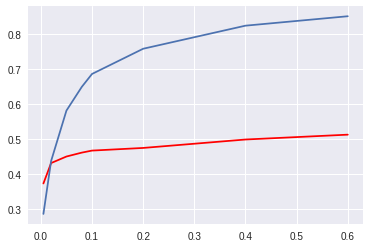

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(percents, scores_rfc, color = 'r')
plt.plot(percents, scores_svc)

## eli5 explanation tool

In [12]:
import eli5
from eli5.lime import TextExplainer

from sklearn.linear_model import SGDClassifier

train, test = train_test_split(df, test_size = 0.33)

clf = SGDClassifier(loss = 'modified_huber')
pipeline = Pipeline([('tf-idf', tf_idf), ('clf', clf)])
pipeline.fit(train['words'],train['author'])
target_names = pipeline.named_steps['clf'].classes_.tolist()

pred = pipeline.predict(test['words'])
score = metrics.f1_score(test['author'], pred, average='micro')
print("F1 score: ", score)

F1 score:  0.876901630402


In [13]:
te = TextExplainer(random_state=42)
te.fit(test['words'].values[0], pipeline.predict_proba)
print("Real Author: ", test['author'].values[0])
te.show_prediction(target_names=target_names)

In [14]:

eli5.show_weights(clf, vec=tf_idf
                  , target_names=target_names, horizontal_layout=True, top=20)


Real Author:  Ф.М. Достоевский
